In [1]:
import chi

chi.use_site("CHI@TACC")
chi.set("project_name", "CHI-220969")
print(f'Using Project {chi.get("project_name")}')

Now using CHI@TACC:
URL: https://chi.tacc.chameleoncloud.org
Location: Austin, Texas, USA
Support contact: help@chameleoncloud.org
Using Project CHI-220969


# Lease/Server

For the experiment, we just need **1** server. We will use Docker to launch 25 instances of hadoop data node and run map reduce task on top of it.

In [2]:
import os
import keystoneauth1, blazarclient
from chi import lease
import time
reservations = []
lease_node_type = "compute_cascadelake_r"
reservation_req_time = int(time.time())

try:
    print("Creating lease...")
    lease.add_fip_reservation(reservations, count=1)
    lease.add_node_reservation(reservations, node_type=lease_node_type, count=1)

    start_date, end_date = lease.lease_duration(hours=6)

    l = lease.create_lease(
        f"{os.getenv('USER')}-yarn-9565-{reservation_req_time}", 
        reservations, 
        start_date=start_date, 
        end_date=end_date
    )
    lease_id = l["id"]

    print("Waiting for lease to start ...")
    lease.wait_for_active(lease_id)
    print("Lease is now active!")
except keystoneauth1.exceptions.http.Unauthorized as e:
    print("Unauthorized.\nDid set your project name and and run the code in the first cell?")
except blazarclient.exception.BlazarClientException as e:
    print(f"There is an issue making the reservation. Check the calendar to make sure a {lease_node_type} node is available.")
    print("https://chi.uc.chameleoncloud.org/project/leases/calendar/host/")
    print(e)
except Exception as e:
    print("An unexpected error happened.")
    print(e)

Creating lease...
Waiting for lease to start ...
Lease is now active!


In [3]:
from chi import server

image = "CC-Ubuntu22.04"
reservation_req_time = int(time.time())
s = server.create_server(
    f"{os.getenv('USER')}-yarn-9565-{reservation_req_time}", 
    image_name=image,
    reservation_id=lease.get_node_reservation(lease_id)
)

print("Waiting for server to start ...")
server.wait_for_active(s.id)
print("Done")

Waiting for server to start ...
Done


In [4]:
floating_ip = lease.get_reserved_floating_ips(lease_id)[0]
server.associate_floating_ip(s.id, floating_ip_address=floating_ip)

print(f"Waiting for SSH connectivity on {floating_ip} ...")
timeout = 60*3
import socket
import time
# Repeatedly try to connect via SSH.
start_time = time.perf_counter()
while True:
    try:
        with socket.create_connection((floating_ip, 22), timeout=timeout):
            print("Connection successful")
            break
    except OSError as ex:
        time.sleep(10)
        if time.perf_counter() - start_time >= timeout:
            print(f"After {timeout} seconds, could not connect via SSH. Please try again.")

Waiting for SSH connectivity on 129.114.109.224 ...
Connection successful


# Machine Setup
We need to configure the machine to have the following components
- Docker
- Unzip (for unzipping corpus for map reduce later)

In [5]:
from chi import ssh
with ssh.Remote(floating_ip) as conn:
    # Upload the script
    conn.put("./scripts/install_docker.sh")
    # # Run the script
    conn.run("chmod +x install_docker.sh")
    conn.run("sudo ./install_docker.sh")
    conn.run("sudo apt install -y unzip")

/opt/conda/lib/python3.10/site-packages/paramiko/client.py:852: UserWarning: Unknown ssh-ed25519 host key for 129.114.109.224: b'8c77fd84bccb61f97754c40760b24b8d'
  warnings.warn(


Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1467 kB]
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1678 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.4 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1866 kB]
Get:9 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1923 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [520 B]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [852 kB]
Get:12 http://security.ubuntu.com/ubuntu 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 484 kB in 1s (545 kB/s)
(Reading database ... 83973 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.16_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.16) over (7.81.0-1ubuntu1.15) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.16_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.16) over (7.81.0-1ubuntu1.15) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.16) ...
Setting up curl (7.81.0-1ubuntu1.16) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.6) ...

Running kernel seems to be up-to-date.

The processor microcode seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Get:1 https://download.docker.com/linux/ubuntu jammy InRelease [48.8 kB]
Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 h

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 112 MB in 2s (54.6 MB/s)
Selecting previously unselected package containerd.io.
(Reading database ... 83973 files and directories currently installed.)
Preparing to unpack .../containerd.io_1.6.31-1_amd64.deb ...
Unpacking containerd.io (1.6.31-1) ...
Selecting previously unselected package docker-buildx-plugin.
Preparing to unpack .../docker-buildx-plugin_0.14.0-1~ubuntu.22.04~jammy_amd64.deb ...
Unpacking docker-buildx-plugin (0.14.0-1~ubuntu.22.04~jammy) ...
Selecting previously unselected package docker-ce-cli.
Preparing to unpack .../docker-ce-cli_5%3a26.1.2-1~ubuntu.22.04~jammy_amd64.deb ...
Unpacking docker-ce-cli (5:26.1.2-1~ubuntu.22.04~jammy) ...
Selecting previously unselected package docker-ce.
Preparing to unpack .../docker-ce_5%3a26.1.2-1~ubuntu.22.04~jammy_amd64.deb ...
Unpacking docker-ce (5:26.1.2-1~ubuntu.22.04~jammy) ...
Selecting previously unselected package docker-compose-plugin.
Preparing to unpack .../docker-compose-plugin_2.27.0-1~ubuntu.22.04~jammy_amd

Reading package lists...
Building dependency tree...
Reading state information...
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 58 not upgraded.
Need to get 175 kB of archives.
After this operation, 386 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/main amd64 unzip amd64 6.0-26ubuntu3.2 [175 kB]


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 175 kB in 0s (627 kB/s)
Selecting previously unselected package unzip.
(Reading database ... 84206 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-26ubuntu3.2_amd64.deb ...
Unpacking unzip (6.0-26ubuntu3.2) ...
Setting up unzip (6.0-26ubuntu3.2) ...
Processing triggers for man-db (2.10.2-1) ...

Running kernel seems to be up-to-date.

The processor microcode seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.


In [6]:
# Test docker is working by running Hello World example
with ssh.Remote(floating_ip) as conn:
    conn.run("sudo docker run hello-world")

Unable to find image 'hello-world:latest' locally
latest: Pulling from library/hello-world
c1ec31eb5944: Pulling fs layer
c1ec31eb5944: Download complete
c1ec31eb5944: Pull complete
Digest: sha256:a26bff933ddc26d5cdf7faa98b4ae1e3ec20c4985e6f87ac0973052224d24302
Status: Downloaded newer image for hello-world:latest



Hello from Docker!
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
    (amd64)
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker ID:
 https://hub.docker.com/

For more examples and ideas, visit:
 https://docs.docker.com/get-started/



# Getting the Code / Compiling
The code for the reproduction experiment is publicly accessible at https://github.com/jiajunmao/hadoop-repro.
1. We will first clone the code it to the machine.
2. We will then start the official dev docker. This allows us to get a working dev env wtih one line of command rather than setting up all the dependencies and build kits.
    - **Note**: that after the second sell run, we will spawn a long running docker container called `hadoop-repro`. We modified the `start-build-env.sh` a little bit from the official source code. In the official source code, the docker is started in an interactive manner and will self-destruct once we exit the interactive shell.
    - **Note**: the second cell is going to take a while (10-20 minutes)

3. We will then compile the hadoop source code in the docker

In [7]:
# Clone 
with ssh.Remote(floating_ip) as conn:
    conn.run("git clone https://github.com/jiajunmao/hadoop-repro")

Cloning into 'hadoop-repro'...
Updating files: 100% (14331/14331), done.


In [8]:
# Starting the build docker for hadoop (this is going to take a while)
# Note we pipe the output into a log file because otherwise its going to crash the browser (jupyter lab)

with ssh.Remote(floating_ip) as conn:
    conn.run("cd hadoop-repro && sudo ./start-build-env.sh")

#0 building with "default" instance using docker driver

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 6.70kB done
#1 DONE 0.0s

#2 [internal] load metadata for docker.io/library/ubuntu:xenial
#2 DONE 0.7s

#3 [internal] load .dockerignore
#3 transferring context: 2B done
#3 DONE 0.0s

#4 [internal] load build context
#4 transferring context: 3.70kB done
#4 DONE 0.0s

#5 [ 1/21] FROM docker.io/library/ubuntu:xenial@sha256:1f1a2d56de1d604801a9671f301190704c25d604a416f59e03c04f5c6ffee0d6
#5 resolve docker.io/library/ubuntu:xenial@sha256:1f1a2d56de1d604801a9671f301190704c25d604a416f59e03c04f5c6ffee0d6 done
#5 sha256:b6f50765242581c887ff1acc2511fa2d885c52d8fb3ac8c4bba131fd86567f2e 3.36kB / 3.36kB done
#5 sha256:58690f9b18fca6469a14da4e212c96849469f9b1be6661d2342a4bf01774aa50 0B / 46.50MB 0.1s
#5 sha256:b51569e7c50720acf6860327847fe342a1afbe148d24c529fb81df105e3eed01 857B / 857B 0.1s done
#5 sha256:da8ef40b9ecabc2679fe2419957220c0272a965c5cf7e0269fa1aeeb8c5

4284cc6a983eee9f9021ae4fc2e82f16d62cde05862611c00cf1e0958703c4b4


In [ ]:
# Build the hadoop tar and binary using the dev docker (we skip running the unit test, otherwise its going to take >5 hours)
# Note we pipe the output into a log file because otherwise its going to crash the browser (jupyter lab)

with ssh.Remote(floating_ip) as conn:
    conn.run("sudo mkdir -p /home/cc/.m2/repository")
    conn.run("sudo chown -R cc:cc /home/cc/.m2/repository")
    conn.run('sudo docker exec hadoop-repro bash -c "sudo mvn -nsu clean package -Pdist -DskipTests -Dtar -Dmaven.javadoc.skip=true"')

# Building the Dockerfile for Hadoop
In this section we are going to take the previous compilation result (tar ball) and generate a Docker image that will run HDFS data node/name node and YARN AM/RM. This will ease the creation of multiple hadoop nodes (in pseudo-distributed way because we are running them on a single machine).
The Dockerfile does the following
1. Copy the tar ball from `hadoop-dist/target`
2. Setup some needed directories and dependencies

In [11]:
with ssh.Remote(floating_ip) as conn:
    conn.run("cd hadoop-repro/dockers && sudo docker build --no-cache -t hdfs-repro:latest -f Dockerfile ..")

#0 building with "default" instance using docker driver

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 1.99kB done
#1 DONE 0.0s

#2 [internal] load metadata for docker.io/library/eclipse-temurin:11
#2 DONE 0.5s

#3 [internal] load .dockerignore
#3 transferring context: 2B done
#3 DONE 0.0s

#4 [ 1/23] FROM docker.io/library/eclipse-temurin:11@sha256:882268264cb1cc64627bfd6b81efa122c93ea23f6ddf1d894f72db02efb11234
#4 DONE 0.0s

#5 [ 2/23] WORKDIR /opt
#5 CACHED

#6 [internal] load build context
#6 transferring context: 451.15MB 4.9s done
#6 DONE 4.9s

#7 [ 3/23] COPY ./hadoop-dist/target/hadoop-3.3.0.tar.gz /opt
#7 DONE 2.4s

#8 [ 4/23] RUN tar -xvf hadoop-3.3.0.tar.gz -C /opt
#8 0.190 hadoop-3.3.0/
#8 0.190 hadoop-3.3.0/LICENSE.txt
#8 0.190 hadoop-3.3.0/libexec/
#8 0.190 hadoop-3.3.0/libexec/yarn-config.cmd
#8 0.190 hadoop-3.3.0/libexec/mapred-config.cmd
#8 0.190 hadoop-3.3.0/libexec/hdfs-config.sh
#8 0.190 hadoop-3.3.0/libexec/mapred-config.sh
#8 0.19

# Patch Introduction
The patch for YARN-9565 is **1** line, which is `app.ranNodes.clear();`. The memory leak is caused by `ranNodes` set not being cleared after a YARN app is transitioned into terminal state. Therefore, to reproduce this bug and see the effect of the patch, we just need to monitor the memory usage of the `ranNodes` field after each YARN app run. To make the reproduction easier, we have made the following code changes
1. Originally, ranNodes is a `ConcurrentSkipListSet`, which is a generic Java set that's used in multiple places in YARN code. Therefore, its not that easy to tell which instance of the set is referencing to `ranNodes`.
2. We created a new class called `CustomConcurrentSkipListSet` which extends `ConcurrentSkipListSet` like the following
```java
package org.apache.hadoop.yarn.server.resourcemanager.rmapp;

import java.util.concurrent.ConcurrentSkipListSet;

public class CustomConcurrentSkipListSet<T> extends ConcurrentSkipListSet<T> {
    
}
```
3. We replace the field type of `ranNodes` from `ConcurrentSkipListSet` to `CustomConcurrentSkipListSet` so that its immediately visible in the java heap dump
4. We also wrap the `app.ranNodes.clear();` statement in a `System.getenv()` call (reading environmental variable). So that the enablement of this patch can be controlled via env-var without needing to recompile the whole source code, which is time consuming.

# Data Collection before the Patch
In this section we are going to run the Hadoop cluster with `APP_RANNODES_CLEAR` environment variable set to `false` by using the docker-compose file `scripts/docker-compose-before.yml`

For the experiment, we are going to have the following
- 25 YARN AM(Application Master)
- 1 YARN RM(Resource Manager)
- WordCount MapReduce task as YARN app
- Counting bible repeated 25 times (~150MB)
    - The bible is from the Cantebury Corpus Site https://corpus.canterbury.ac.nz/ (The Large Corpus Section)

The reason for repeating the bible is that we need to make sure the input into the map reduce task is big enough so that we schedule at least one job on each of the datanode

In [12]:
with ssh.Remote(floating_ip) as conn:
    conn.put('./scripts/docker-compose-before.yml', '/home/cc/hadoop-repro/dockers/')
    conn.run("cd hadoop-repro/dockers && sudo docker compose -f docker-compose-before.yml stop")
    conn.run("cd hadoop-repro/dockers && sudo docker compose -f docker-compose-before.yml rm -f")
    conn.run("cd hadoop-repro/dockers && sudo docker compose -f docker-compose-before.yml up -d")

time="2024-05-16T02:43:21Z" level=warning msg="/home/cc/hadoop-repro/dockers/docker-compose-before.yml: `version` is obsolete"
time="2024-05-16T02:43:21Z" level=warning msg="/home/cc/hadoop-repro/dockers/docker-compose-before.yml: `version` is obsolete"
No stopped containers
time="2024-05-16T02:43:21Z" level=warning msg="/home/cc/hadoop-repro/dockers/docker-compose-before.yml: `version` is obsolete"
 Network hadoop-repro_intra  Creating
 Network hadoop-repro_intra  Created
 Container hadoop-repro-namenode-1  Creating
 Container hadoop-repro-datanode-4  Creating
 Container hadoop-repro-datanode-1  Creating
 Container hadoop-repro-datanode-25  Creating
 Container hadoop-repro-datanode-9  Creating
 Container hadoop-repro-datanode-14  Creating
 Container hadoop-repro-datanode-19  Creating
 Container hadoop-repro-datanode-2  Creating
 Container hadoop-repro-datanode-22  Creating
 Container hadoop-repro-datanode-10  Creating
 Container hadoop-repro-datanode-12  Creating
 Container hadoop-rep

In [13]:
# Make sure that all the yarn nodes are up (Yarn shows nodes running, HDFS should show about 18TB of DFS capacity)
with ssh.Remote(floating_ip) as conn:
    conn.run("sudo docker exec hadoop-repro-namenode-1 yarn node -list -all")
    conn.run("sudo docker exec hadoop-repro-namenode-1 hdfs dfsadmin -report")

2024-05-16 02:44:17,808 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-05-16 02:44:17,885 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at namenode/172.18.0.2:8032


Total Nodes:25
         Node-Id	     Node-State	Node-Http-Address	Number-of-Running-Containers
11549bd5c403:34623	        RUNNING	11549bd5c403:8042	                           0
c4839ba9c176:41457	        RUNNING	c4839ba9c176:8042	                           0
e742599bf780:39425	        RUNNING	e742599bf780:8042	                           0
c87e605cc874:43895	        RUNNING	c87e605cc874:8042	                           0
fa8906ff1c6e:38745	        RUNNING	fa8906ff1c6e:8042	                           0
0040a4a58cb8:37783	        RUNNING	0040a4a58cb8:8042	                           0
ef7c5d2d51ad:35445	        RUNNING	ef7c5d2d51ad:8042	                           0
11983b201717:39889	        RUNNING	11983b201717:8042	                           0
79b61131928b:38261	        RUNNING	79b61131928b:8042	                           0
07f5c2acee6a:35131	        RUNNING	07f5c2acee6a:8042	                           0
af473aa45d2d:42063	        RUNNING	af473aa45d2d:8042	                           0
c88

2024-05-16 02:44:18,877 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Configured Capacity: 22485948620800 (20.45 TB)
Present Capacity: 20769592745984 (18.89 TB)
DFS Remaining: 20769591517184 (18.89 TB)
DFS Used: 1228800 (1.17 MB)
DFS Used%: 0.00%
Replicated Blocks:
	Under replicated blocks: 0
	Blocks with corrupt replicas: 0
	Missing blocks: 0
	Missing blocks (with replication factor 1): 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0
Erasure Coded Block Groups: 
	Low redundancy block groups: 0
	Block groups with corrupt internal blocks: 0
	Missing block groups: 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0

-------------------------------------------------
Live datanodes (25):

Name: 172.18.0.10:9866 (hadoop-repro-datanode-9.hadoop-repro_intra)
Hostname: c8853658128a
Rack: /rack-10
Decommission Status : Normal
Configured Capacity: 899437944832 (837.67 GB)
DFS Used: 49152 (48 KB)
Non DFS Used: 30142824448 (28.07 GB)
DFS Remaining: 830783643648 (773.73 GB)
DFS Used%: 0.00%

In [14]:
# Download the bible within the namenode docker
with ssh.Remote(floating_ip) as conn:
    conn.run("sudo docker exec hadoop-repro-namenode-1 wget http://corpus.canterbury.ac.nz/resources/large.zip")
    conn.run("sudo docker exec hadoop-repro-namenode-1 apt install -y unzip")
    # Clean out remains
    conn.run("sudo docker exec hadoop-repro-namenode-1 rm -rf *.txt")
    conn.run("sudo docker exec hadoop-repro-namenode-1 unzip -o large.zip")
    # Repeat the bible 25 times
    conn.run("sudo docker exec hadoop-repro-namenode-1 du -h bible.txt")
    conn.run("sudo docker exec hadoop-repro-namenode-1 bash -c 'for i in {1..45}; do cat bible.txt >> biblerepeat.txt; done'")
    conn.run("sudo docker exec hadoop-repro-namenode-1 du -h biblerepeat.txt")

--2024-05-16 02:44:23--  http://corpus.canterbury.ac.nz/resources/large.zip
Resolving corpus.canterbury.ac.nz (corpus.canterbury.ac.nz)... 132.181.17.8
Connecting to corpus.canterbury.ac.nz (corpus.canterbury.ac.nz)|132.181.17.8|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://corpus.canterbury.ac.nz/resources/large.zip [following]
--2024-05-16 02:44:25--  https://corpus.canterbury.ac.nz/resources/large.zip
Connecting to corpus.canterbury.ac.nz (corpus.canterbury.ac.nz)|132.181.17.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3256280 (3.1M) [application/zip]
Saving to: ‘large.zip’

     0K .......... .......... .......... .......... ..........  1%  124K 25s
    50K .......... .......... .......... .......... ..........  3%  248K 19s
   100K .......... .......... .......... .......... ..........  4%  125K 20s
   150K .......... .......... .......... .......... ..........  6%  249K 18s
   200K .......... .....

Reading package lists...
Building dependency tree...
Reading state information...
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 175 kB of archives.
After this operation, 386 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 unzip amd64 6.0-26ubuntu3.2 [175 kB]


debconf: delaying package configuration, since apt-utils is not installed


Fetched 175 kB in 0s (542 kB/s)
Selecting previously unselected package unzip.
(Reading database ... 13180 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-26ubuntu3.2_amd64.deb ...
Unpacking unzip (6.0-26ubuntu3.2) ...
Setting up unzip (6.0-26ubuntu3.2) ...
Archive:  large.zip
  inflating: bible.txt               
  inflating: E.coli                  
  inflating: world192.txt            
3.9M	bible.txt
174M	biblerepeat.txt


In [15]:
# Run map reduce on biblerepeat.txt for 5 times
with ssh.Remote(floating_ip) as conn:
    conn.run("sudo docker exec hadoop-repro-namenode-1 hdfs dfs -put -f biblerepeat.txt /wordcount/input")
    conn.run("sudo docker exec hadoop-repro-namenode-1 rm -rf dump*")
    for i in range(10):
        # Run the mapreduce
        conn.run("sudo docker exec hadoop-repro-namenode-1 ./hadoop-3.3.0/bin/hadoop jar ./hadoop-3.3.0/share/hadoop/mapreduce/hadoop-mapreduce-examples-3.3.0.jar wordcount /wordcount/input /wordcount/output")
        # Get the pid
        conn.put('./scripts/get_rm_pid.sh')
        conn.run('sudo docker cp get_rm_pid.sh hadoop-repro-namenode-1:/opt/')
        conn.run('sudo docker exec hadoop-repro-namenode-1 chmod +x ./get_rm_pid.sh')
        pid = conn.run('sudo docker exec hadoop-repro-namenode-1 bash get_rm_pid.sh')
        conn.run('sudo docker exec hadoop-repro-namenode-1 jmap -dump:format=b,file=dump-previous-{}.bin {}'.format(i, pid.stdout))
        conn.run('sudo docker exec hadoop-repro-namenode-1 hdfs dfs -rm -r /wordcount/output')

2024-05-16 02:44:43,640 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-05-16 02:44:52,225 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-05-16 02:44:52,733 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at namenode/172.18.0.2:8032
2024-05-16 02:44:53,076 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1715827413982_0001
2024-05-16 02:44:53,418 INFO input.FileInputFormat: Total input files to process : 1
2024-05-16 02:44:53,535 INFO mapreduce.JobSubmitter: number of splits:174
2024-05-16 02:44:53,730 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1715827413982_0001
2024-05-16 02:44:53,731 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-05-16 02:44:53,854 INFO conf.Configuration: resource-types.

467
Dumping heap to /opt/dump-previous-0.bin ...
Heap dump file created [360763556 bytes in 1.597 secs]


2024-05-16 02:45:37,260 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Deleted /wordcount/output


2024-05-16 02:45:38,690 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-05-16 02:45:39,216 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at namenode/172.18.0.2:8032
2024-05-16 02:45:39,562 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1715827413982_0002
2024-05-16 02:45:39,870 INFO input.FileInputFormat: Total input files to process : 1
2024-05-16 02:45:39,953 INFO mapreduce.JobSubmitter: number of splits:174
2024-05-16 02:45:40,092 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1715827413982_0002
2024-05-16 02:45:40,092 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-05-16 02:45:40,217 INFO conf.Configuration: resource-types.xml not found
2024-05-16 02:45:40,217 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2024-05-16 02:45:40,273 INFO impl.YarnClientImpl: 

467
Dumping heap to /opt/dump-previous-1.bin ...
Heap dump file created [421816635 bytes in 1.923 secs]


2024-05-16 02:46:20,769 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Deleted /wordcount/output


2024-05-16 02:46:22,200 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-05-16 02:46:22,713 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at namenode/172.18.0.2:8032
2024-05-16 02:46:23,016 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1715827413982_0003
2024-05-16 02:46:23,312 INFO input.FileInputFormat: Total input files to process : 1
2024-05-16 02:46:23,393 INFO mapreduce.JobSubmitter: number of splits:174
2024-05-16 02:46:23,528 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1715827413982_0003
2024-05-16 02:46:23,528 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-05-16 02:46:23,653 INFO conf.Configuration: resource-types.xml not found
2024-05-16 02:46:23,653 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2024-05-16 02:46:23,698 INFO impl.YarnClientImpl: 

467
Dumping heap to /opt/dump-previous-2.bin ...
Heap dump file created [474642036 bytes in 2.349 secs]


2024-05-16 02:47:05,487 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Deleted /wordcount/output


2024-05-16 02:47:06,901 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-05-16 02:47:07,454 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at namenode/172.18.0.2:8032
2024-05-16 02:47:07,744 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1715827413982_0004
2024-05-16 02:47:07,980 INFO input.FileInputFormat: Total input files to process : 1
2024-05-16 02:47:08,073 INFO mapreduce.JobSubmitter: number of splits:174
2024-05-16 02:47:08,271 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1715827413982_0004
2024-05-16 02:47:08,271 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-05-16 02:47:08,394 INFO conf.Configuration: resource-types.xml not found
2024-05-16 02:47:08,395 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2024-05-16 02:47:08,441 INFO impl.YarnClientImpl: 

467
Dumping heap to /opt/dump-previous-3.bin ...
Heap dump file created [516182292 bytes in 2.628 secs]


2024-05-16 02:47:50,423 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Deleted /wordcount/output


2024-05-16 02:47:51,863 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-05-16 02:47:52,396 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at namenode/172.18.0.2:8032
2024-05-16 02:47:52,683 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1715827413982_0005
2024-05-16 02:47:52,957 INFO input.FileInputFormat: Total input files to process : 1
2024-05-16 02:47:53,060 INFO mapreduce.JobSubmitter: number of splits:174
2024-05-16 02:47:53,264 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1715827413982_0005
2024-05-16 02:47:53,264 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-05-16 02:47:53,385 INFO conf.Configuration: resource-types.xml not found
2024-05-16 02:47:53,385 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2024-05-16 02:47:53,433 INFO impl.YarnClientImpl: 

467
Dumping heap to /opt/dump-previous-4.bin ...
Heap dump file created [568766066 bytes in 2.903 secs]


2024-05-16 02:48:35,586 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Deleted /wordcount/output


2024-05-16 02:48:37,039 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-05-16 02:48:37,556 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at namenode/172.18.0.2:8032
2024-05-16 02:48:37,854 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1715827413982_0006
2024-05-16 02:48:38,102 INFO input.FileInputFormat: Total input files to process : 1
2024-05-16 02:48:38,197 INFO mapreduce.JobSubmitter: number of splits:174
2024-05-16 02:48:38,397 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1715827413982_0006
2024-05-16 02:48:38,397 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-05-16 02:48:38,530 INFO conf.Configuration: resource-types.xml not found
2024-05-16 02:48:38,530 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2024-05-16 02:48:38,579 INFO impl.YarnClientImpl: 

467
Dumping heap to /opt/dump-previous-5.bin ...
Heap dump file created [624366820 bytes in 3.363 secs]


2024-05-16 02:49:21,038 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Deleted /wordcount/output


2024-05-16 02:49:22,511 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-05-16 02:49:23,039 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at namenode/172.18.0.2:8032
2024-05-16 02:49:23,381 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1715827413982_0007
2024-05-16 02:49:23,652 INFO input.FileInputFormat: Total input files to process : 1
2024-05-16 02:49:23,751 INFO mapreduce.JobSubmitter: number of splits:174
2024-05-16 02:49:23,923 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1715827413982_0007
2024-05-16 02:49:23,923 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-05-16 02:49:24,049 INFO conf.Configuration: resource-types.xml not found
2024-05-16 02:49:24,050 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2024-05-16 02:49:24,105 INFO impl.YarnClientImpl: 

467
Dumping heap to /opt/dump-previous-6.bin ...
Heap dump file created [669106920 bytes in 3.678 secs]


2024-05-16 02:50:07,002 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Deleted /wordcount/output


2024-05-16 02:50:08,466 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-05-16 02:50:08,991 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at namenode/172.18.0.2:8032
2024-05-16 02:50:09,298 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1715827413982_0008
2024-05-16 02:50:09,684 INFO input.FileInputFormat: Total input files to process : 1
2024-05-16 02:50:09,905 INFO mapreduce.JobSubmitter: number of splits:174
2024-05-16 02:50:10,170 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1715827413982_0008
2024-05-16 02:50:10,170 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-05-16 02:50:10,321 INFO conf.Configuration: resource-types.xml not found
2024-05-16 02:50:10,321 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2024-05-16 02:50:10,370 INFO impl.YarnClientImpl: 

467
Dumping heap to /opt/dump-previous-7.bin ...
Heap dump file created [714596861 bytes in 3.975 secs]


2024-05-16 02:50:52,423 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Deleted /wordcount/output


2024-05-16 02:50:53,910 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-05-16 02:50:54,451 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at namenode/172.18.0.2:8032
2024-05-16 02:50:54,756 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1715827413982_0009
2024-05-16 02:50:54,999 INFO input.FileInputFormat: Total input files to process : 1
2024-05-16 02:50:55,095 INFO mapreduce.JobSubmitter: number of splits:174
2024-05-16 02:50:55,300 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1715827413982_0009
2024-05-16 02:50:55,300 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-05-16 02:50:55,419 INFO conf.Configuration: resource-types.xml not found
2024-05-16 02:50:55,419 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2024-05-16 02:50:55,466 INFO impl.YarnClientImpl: 

467
Dumping heap to /opt/dump-previous-8.bin ...
Heap dump file created [771354234 bytes in 4.411 secs]


2024-05-16 02:51:38,860 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Deleted /wordcount/output


2024-05-16 02:51:40,326 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-05-16 02:51:40,867 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at namenode/172.18.0.2:8032
2024-05-16 02:51:41,194 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1715827413982_0010
2024-05-16 02:51:41,505 INFO input.FileInputFormat: Total input files to process : 1
2024-05-16 02:51:41,604 INFO mapreduce.JobSubmitter: number of splits:174
2024-05-16 02:51:41,816 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1715827413982_0010
2024-05-16 02:51:41,816 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-05-16 02:51:41,945 INFO conf.Configuration: resource-types.xml not found
2024-05-16 02:51:41,946 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2024-05-16 02:51:41,997 INFO impl.YarnClientImpl: 

467
Dumping heap to /opt/dump-previous-9.bin ...
Heap dump file created [816844284 bytes in 4.716 secs]


2024-05-16 02:52:25,944 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Deleted /wordcount/output


In [16]:
# We then copy out the dump files into Chameleon host
with ssh.Remote(floating_ip) as conn:
    for i in range(10):
        conn.run("sudo docker cp hadoop-repro-namenode-1:/opt/dump-previous-{}.bin .".format(i))
    
    conn.run("ls -la")

total 5799340
drwxr-x---  8 cc   cc        4096 May 16 02:52 .
drwxr-xr-x  4 root root      4096 May 16 00:52 ..
-rw-------  1 cc   cc         680 May 16 02:22 .bash_history
-rw-r--r--  1 cc   cc         220 Jan  6  2022 .bash_logout
-rw-r--r--  1 cc   cc        3771 Jan  6  2022 .bashrc
drwx------  2 cc   cc        4096 May 16 00:52 .cache
drwx------  4 cc   cc        4096 May 16 02:45 .config
drwxr-xr-x  3 root root      4096 May 16 01:07 .m2
-rw-r--r--  1 cc   cc         807 Jan  6  2022 .profile
drwx------  2 cc   cc        4096 May 16 00:52 .ssh
-rw-r--r--  1 cc   cc           0 May 16 00:52 .sudo_as_admin_successful
-rw-r--r--  1 cc   cc         723 Mar 22 21:06 README
-rw-------  1 root root 360763556 May 16 02:45 dump-previous-0.bin
-rw-------  1 root root 421816635 May 16 02:46 dump-previous-1.bin
-rw-------  1 root root 474642036 May 16 02:47 dump-previous-2.bin
-rw-------  1 root root 516182292 May 16 02:47 dump-previous-3.bin
-rw-------  1 root root 568766066 May 16 02:48 d

# Data collection after the Patch
In this section we are going to get the memory dump data after the patch. We are going to use the `docker-compose-after.yml` file so that we can toggle on the patch code path.
I am going to skip over explaining following cells because they are essentially identical to the above.

In [17]:
with ssh.Remote(floating_ip) as conn:
    ##
    # Start the dockers
    ##
    
    # Put the new docker-compose file over
    conn.put('./scripts/docker-compose-after.yml', '/home/cc/hadoop-repro/dockers/')
    # Stop and remove all previous dockers
    conn.run("cd hadoop-repro/dockers && sudo docker compose -f docker-compose-before.yml stop")
    conn.run("cd hadoop-repro/dockers && sudo docker compose -f docker-compose-before.yml rm -f")
    # Stop and remove all after dockers
    conn.run("cd hadoop-repro/dockers && sudo docker compose -f docker-compose-after.yml stop")
    conn.run("cd hadoop-repro/dockers && sudo docker compose -f docker-compose-after.yml rm -f")
    # Start after dockers
    conn.run("cd hadoop-repro/dockers && sudo docker compose -f docker-compose-after.yml up -d")

time="2024-05-16T02:59:26Z" level=warning msg="/home/cc/hadoop-repro/dockers/docker-compose-before.yml: `version` is obsolete"
 Container hadoop-repro-namenode-1  Stopping
 Container hadoop-repro-datanode-15  Stopping
 Container hadoop-repro-datanode-13  Stopping
 Container hadoop-repro-datanode-3  Stopping
 Container hadoop-repro-datanode-2  Stopping
 Container hadoop-repro-datanode-7  Stopping
 Container hadoop-repro-datanode-21  Stopping
 Container hadoop-repro-datanode-8  Stopping
 Container hadoop-repro-datanode-10  Stopping
 Container hadoop-repro-datanode-17  Stopping
 Container hadoop-repro-datanode-9  Stopping
 Container hadoop-repro-datanode-12  Stopping
 Container hadoop-repro-datanode-6  Stopping
 Container hadoop-repro-datanode-24  Stopping
 Container hadoop-repro-datanode-18  Stopping
 Container hadoop-repro-datanode-4  Stopping
 Container hadoop-repro-datanode-20  Stopping
 Container hadoop-repro-datanode-22  Stopping
 Container hadoop-repro-datanode-1  Stopping
 Contain

Going to remove hadoop-repro-datanode-8, hadoop-repro-datanode-18, hadoop-repro-datanode-13, hadoop-repro-datanode-15, hadoop-repro-datanode-21, hadoop-repro-datanode-23, hadoop-repro-datanode-7, hadoop-repro-datanode-9, hadoop-repro-datanode-3, hadoop-repro-datanode-25, hadoop-repro-datanode-22, hadoop-repro-datanode-16, hadoop-repro-datanode-5, hadoop-repro-datanode-11, hadoop-repro-datanode-17, hadoop-repro-datanode-12, hadoop-repro-datanode-4, hadoop-repro-datanode-6, hadoop-repro-datanode-24, hadoop-repro-datanode-19, hadoop-repro-datanode-10, hadoop-repro-datanode-14, hadoop-repro-datanode-20, hadoop-repro-datanode-1, hadoop-repro-datanode-2, hadoop-repro-namenode-1


 Container hadoop-repro-namenode-1  Removing
 Container hadoop-repro-datanode-21  Removing
 Container hadoop-repro-datanode-15  Removing
 Container hadoop-repro-datanode-3  Removing
 Container hadoop-repro-datanode-8  Removing
 Container hadoop-repro-datanode-24  Removing
 Container hadoop-repro-datanode-14  Removing
 Container hadoop-repro-datanode-23  Removing
 Container hadoop-repro-datanode-7  Removing
 Container hadoop-repro-datanode-5  Removing
 Container hadoop-repro-datanode-17  Removing
 Container hadoop-repro-datanode-16  Removing
 Container hadoop-repro-datanode-11  Removing
 Container hadoop-repro-datanode-10  Removing
 Container hadoop-repro-datanode-19  Removing
 Container hadoop-repro-datanode-25  Removing
 Container hadoop-repro-datanode-2  Removing
 Container hadoop-repro-datanode-4  Removing
 Container hadoop-repro-datanode-1  Removing
 Container hadoop-repro-datanode-6  Removing
 Container hadoop-repro-datanode-12  Removing
 Container hadoop-repro-datanode-20  Removi

In [18]:
# Verify they are up
with ssh.Remote(floating_ip) as conn:
    conn.run("sudo docker exec hadoop-repro-namenode-1 yarn node -list -all")
    conn.run("sudo docker exec hadoop-repro-namenode-1 hdfs dfsadmin -report")

2024-05-16 03:02:23,310 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-05-16 03:02:23,388 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at namenode/172.18.0.3:8032


Total Nodes:25
         Node-Id	     Node-State	Node-Http-Address	Number-of-Running-Containers
02676a4ec0d5:46375	        RUNNING	02676a4ec0d5:8042	                           0
144b8d219495:35105	        RUNNING	144b8d219495:8042	                           0
341deef141f9:44897	        RUNNING	341deef141f9:8042	                           0
ea31dfb37f77:34293	        RUNNING	ea31dfb37f77:8042	                           0
13ab02da017b:40835	        RUNNING	13ab02da017b:8042	                           0
5e093301b18f:32777	        RUNNING	5e093301b18f:8042	                           0
2d2622dfa843:44947	        RUNNING	2d2622dfa843:8042	                           0
a506406e6224:41503	        RUNNING	a506406e6224:8042	                           0
fb516709e629:35949	        RUNNING	fb516709e629:8042	                           0
97224fb342e6:39229	        RUNNING	97224fb342e6:8042	                           0
e74905900df7:44883	        RUNNING	e74905900df7:8042	                           0
70a

2024-05-16 03:02:24,374 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Configured Capacity: 22485948620800 (20.45 TB)
Present Capacity: 20472221818880 (18.62 TB)
DFS Remaining: 20472220590080 (18.62 TB)
DFS Used: 1228800 (1.17 MB)
DFS Used%: 0.00%
Replicated Blocks:
	Under replicated blocks: 0
	Blocks with corrupt replicas: 0
	Missing blocks: 0
	Missing blocks (with replication factor 1): 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0
Erasure Coded Block Groups: 
	Low redundancy block groups: 0
	Block groups with corrupt internal blocks: 0
	Missing block groups: 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0

-------------------------------------------------
Live datanodes (25):

Name: 172.18.0.10:9866 (hadoop-repro-datanode-8.hadoop-repro_intra)
Hostname: 70a6ec96f858
Rack: /rack-10
Decommission Status : Normal
Configured Capacity: 899437944832 (837.67 GB)
DFS Used: 49152 (48 KB)
Non DFS Used: 42037657600 (39.15 GB)
DFS Remaining: 818888810496 (762.65 GB)
DFS Used%: 0.00%

In [ ]:
with ssh.Remote(floating_ip) as conn:
    ##
    # Generate the word load data
    ##
    conn.run("sudo docker exec hadoop-repro-namenode-1 wget http://corpus.canterbury.ac.nz/resources/large.zip")
    conn.run("sudo docker exec hadoop-repro-namenode-1 apt install -y unzip")
    # Clean out remains
    conn.run("sudo docker exec hadoop-repro-namenode-1 rm -rf *.txt")
    conn.run("sudo docker exec hadoop-repro-namenode-1 unzip -o large.zip")
    # Repeat the bible 25 times
    conn.run("sudo docker exec hadoop-repro-namenode-1 du -h bible.txt")
    conn.run("sudo docker exec hadoop-repro-namenode-1 bash -c 'for i in {1..45}; do cat bible.txt >> biblerepeat.txt; done'")
    conn.run("sudo docker exec hadoop-repro-namenode-1 du -h biblerepeat.txt")
    
    ##
    # Run the map reduce for 5 times
    ##
    conn.run("sudo docker exec hadoop-repro-namenode-1 hdfs dfs -put biblerepeat.txt /wordcount/input")
    conn.run("sudo docker exec hadoop-repro-namenode-1 rm -rf dump*")
    for i in range(10):
        # Run the mapreduce
        conn.run("sudo docker exec hadoop-repro-namenode-1 ./hadoop-3.3.0/bin/hadoop jar ./hadoop-3.3.0/share/hadoop/mapreduce/hadoop-mapreduce-examples-3.3.0.jar wordcount /wordcount/input /wordcount/output")
        # Get the pid
        conn.put('./scripts/get_rm_pid.sh')
        conn.run('sudo docker cp get_rm_pid.sh hadoop-repro-namenode-1:/opt/')
        conn.run('sudo docker exec hadoop-repro-namenode-1 chmod +x ./get_rm_pid.sh')
        pid = conn.run('sudo docker exec hadoop-repro-namenode-1 bash get_rm_pid.sh')
        conn.run('sudo docker exec hadoop-repro-namenode-1 jmap -dump:format=b,file=dump-after-{}.bin {}'.format(i, pid.stdout))
        conn.run('sudo docker exec hadoop-repro-namenode-1 hdfs dfs -rm -r /wordcount/output')
        
    ##
    # Copy out the dump
    ##
    for i in range(10):
        conn.run("sudo docker cp hadoop-repro-namenode-1:/opt/dump-after-{}.bin .".format(i))
    
    conn.run("ls -la")

# Parse the dump result
**Unfortunately**, this step must be completed manually. I tried to come up with a programmatic way of analyzing Java heap dump but it is going to take more time than necessary. So please download VisualVM from https://visualvm.github.io/
To get the memory usage by `ranNodes` field after each map reduce run, follow the steps
1. Open the dump file in the VisualVM
2. At the bottom right, click **Compute Retained Size**
3. Go to the bottom right section **Classes by Sizes of Instances**, click **View All**
4. At the bottom Class Filter, search for **ConcurrentSkipListMap**
5. Find the line where it shows `ConcurrentSkipListMap$Nodes`, this is the line that represent all the contents in the `ranNodes` set
6. Note down the **Retained Size** on the right, and put that into the plotting script provided below
7. Repeat this process for all 10 previous/after dumps
    - I personally only used 5 dumps, because I believe it is already enough to show the trend


Script below is going to bundle the dumps into the jupyter notebook space for download.

**WARNING**: zipping them and transferring them to the juypter notebook space might take a long time (1 hour), it might be more preferable to just check the machine ip address and `scp` all the files to your local machine

In [ ]:
with ssh.Remote(floating_ip) as conn:
    conn.run("sudo apt install -y zip")
    conn.run("sudo chown -R cc:cc dump*")
    conn.run("zip -r -q -9 result.zip dump*")
    conn.get("result.zip")

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  zip
0 upgraded, 1 newly installed, 0 to remove and 58 not upgraded.
Need to get 176 kB of archives.
After this operation, 544 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/main amd64 zip amd64 3.0-12build2 [176 kB]


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 176 kB in 0s (621 kB/s)
Selecting previously unselected package zip.
(Reading database ... 84224 files and directories currently installed.)
Preparing to unpack .../zip_3.0-12build2_amd64.deb ...
Unpacking zip (3.0-12build2) ...
Setting up zip (3.0-12build2) ...
Processing triggers for man-db (2.10.2-1) ...

Running kernel seems to be up-to-date.

The processor microcode seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.


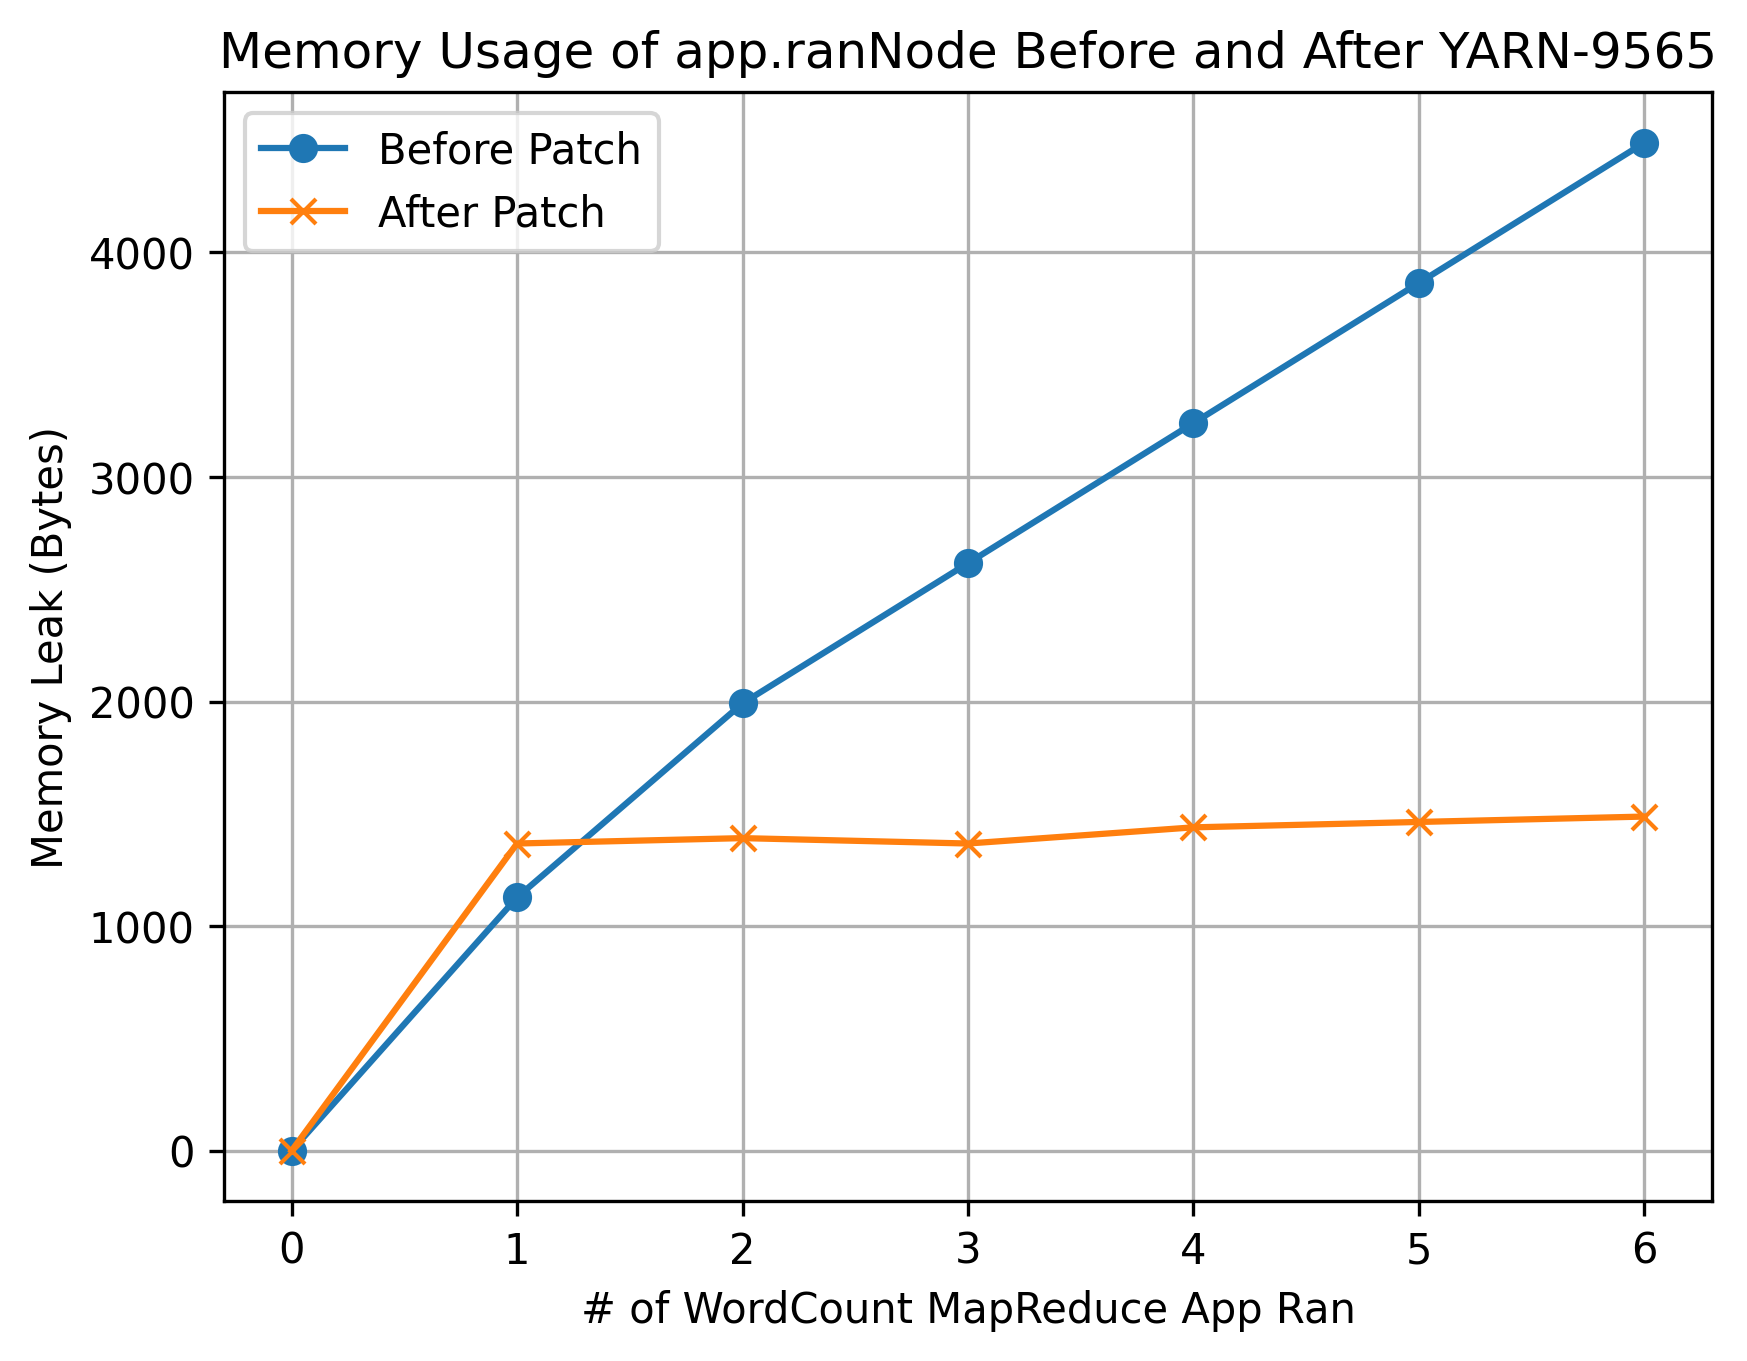

<Figure size 640x480 with 0 Axes>

In [3]:
# Use this script to plot the same plot as in ed stem post  

# The number should match exactly, but if not, feel free to change
data_previous = [0,1128,1992,2616,3240,3864,4488]
data_after = [0,1368,1392,1368,1440,1464,1488]
xticks = range(len(data_after))

import matplotlib.pyplot as plt

plt.plot(xticks, data_previous, label='Before Patch', marker='o')
plt.plot(xticks, data_after, label='After Patch', marker='x')
plt.title("Memory Usage of app.ranNode Before and After YARN-9565")
plt.ylabel("Memory Leak (Bytes)")
plt.xlabel("# of WordCount MapReduce App Ran")
plt.legend(loc='upper left')
plt.grid()
plt.gcf().set_dpi(300)
plt.show()
plt.savefig('repro-graph.png', dpi=300)
